# Initial Setup

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [0]:
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip
import wandb
wandb.login()

In [0]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import cv2
from imutils import paths

tf.random.set_seed(666)
np.random.seed(666)

# Getting ImageNet Subset

In [0]:
!git clone https://github.com/thunderInfy/imagenet-5-categories

In [0]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))


In [0]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (128,128))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [7]:

X_train, y_train = prepare_images(train_images)
X_test, y_test = prepare_images(test_images)


(1250, 128, 128, 3) (1250,)



(250, 128, 128, 3) (250,)


# Building the model

In [0]:
# Reference: https://github.com/wangz10/contrastive_loss/blob/master/model.py
class UnitNormLayer(tf.keras.layers.Layer):
    '''Normalize vectors (euclidean norm) in batch to unit hypersphere.
    '''
    def __init__(self):
        super(UnitNormLayer, self).__init__()

    def call(self, input_tensor):
        norm = tf.norm(input_tensor, axis=1)
        return input_tensor / tf.reshape(norm, [-1, 1])

In [0]:
# Encoder Network
def encoder_net():
	inputs = Input((128, 128,3))
	normalization_layer = UnitNormLayer()

	encoder = tf.keras.applications.ResNet50(weights=None, include_top=False)
	encoder.trainable = False

	embeddings = encoder(inputs, training=False)
	embeddings = GlobalAveragePooling2D()(embeddings)
	norm_embeddings = normalization_layer(embeddings)

	encoder_network = Model(inputs, norm_embeddings)

	return encoder_network

# Projector Network
def projector_net():
  projector = tf.keras.models.Sequential([Dense(256, activation="relu", trainable=False),UnitNormLayer()])
  return projector

In [0]:
encoder=encoder_net()
projector=projector_net()

In [11]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet50 (Model)             multiple                  23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
unit_norm_layer (UnitNormLay (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
projector.build((None,2048))
projector.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  524544    
_________________________________________________________________
unit_norm_layer_1 (UnitNormL multiple                  0         
Total params: 524,544
Trainable params: 0
Non-trainable params: 524,544
_________________________________________________________________


# Model with RMSprop

## Loading saved weights

In [0]:
encoder.load_weights("/content/SCL_encoder_RMS.h5")

In [0]:
projector.load_weights("/content/SCL_projector_RMS.h5")

## Running Forward Passes

In [0]:
encoded_vector=encoder.predict(X_train)

In [0]:
projected_vector=projector.predict(encoded_vector)

## Visualizing the embeddings.

In [13]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:

import os
os.environ['WANDB_DISABLE_CODE'] = 'True'

In [0]:
def plot_embeddings(emb,labels):
  tl=TSNE()
  embedding=tl.fit_transform(emb)
  fig = plt.figure(figsize = (10, 10))
  sns.scatterplot(embedding[:,0], embedding[:,1], hue=labels)
  plt.show()

  return fig

In [16]:
wandb.init(entity='authors',project='scl',id='Visualisations_for_ImageNet_subset')

W&B Run: https://app.wandb.ai/authors/scl/runs/Visualisations_for_ImageNet_subset

### Encoded embeddings with t-SNE

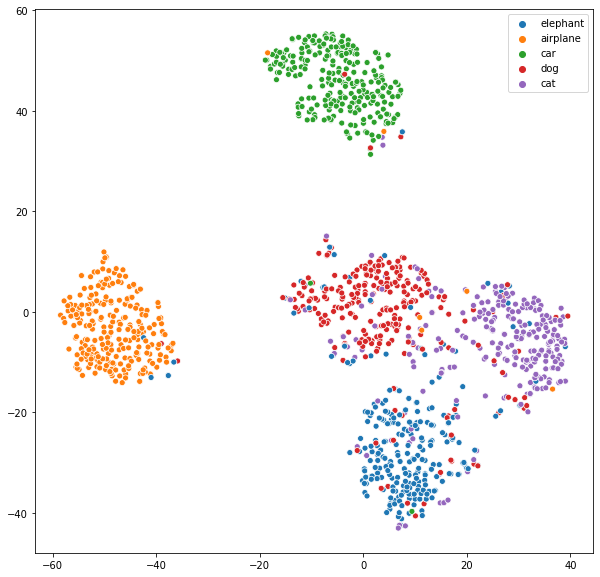

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [21]:
fig = plot_embeddings(encoded_vector,y_train)

wandb.log(({"plotting encoded vectors using RMSprop with t-SNE": fig}))

### Projected embeddings with t-SNE

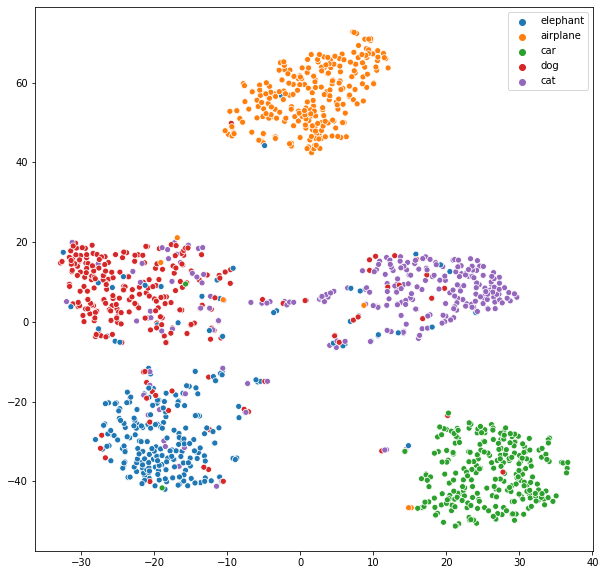

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [22]:
fig = plot_embeddings(projected_vector,y_train)

wandb.log(({"plotting projected vectors using RMSprop with t-SNE": fig}))

# Model with Adam

## Loading Saved weights

In [0]:
encoder.load_weights("/content/SCL_encoder_Adam.h5")

In [0]:
projector.load_weights("/content/SCL_projector_Adam.h5")

## Sending input to the network

In [0]:
encoded_vector=encoder.predict(X_train)
projected_vector=projector.predict(encoded_vector)

## Visualizing the embeddings

### Encoded embeddings with t-SNE

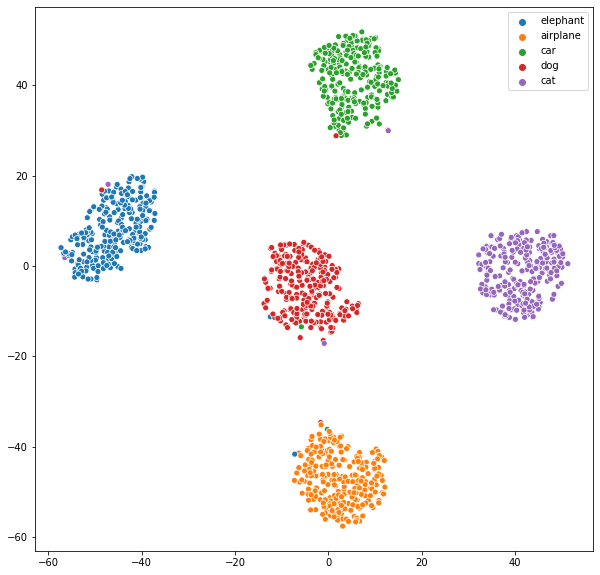

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [26]:
fig = plot_embeddings(encoded_vector,y_train)

wandb.log(({"plotting encoded vectors using Adam with t-SNE": fig}))

### Projected embeddings with t-SNE

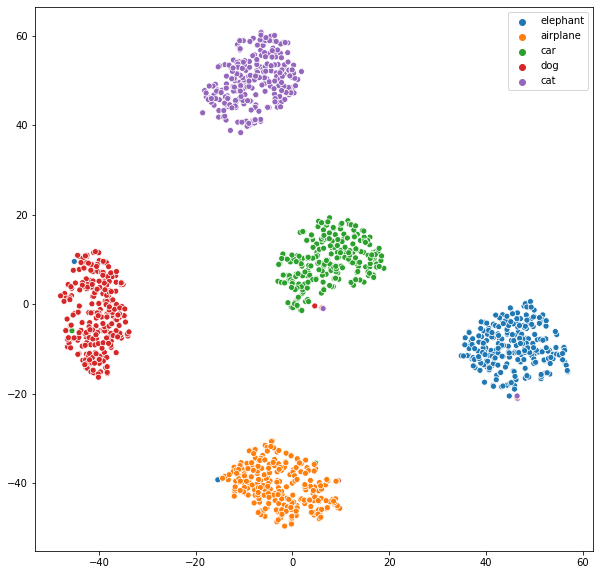

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [27]:
fig = plot_embeddings(projected_vector,y_train)

wandb.log(({"plotting projected vectors using Adam with t-SNE": fig}))